In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

# Modeling the Manipulator

To start, the classes "Manipulator" and "Link" were created that allows the representation of the specifications of manipulators. These classes will be used later on to generate the data required for the manipulators we will train our models to compute the inverse kinematics for. For an instance of this class to be instantiated, the Denavit-Hartenberg (DH) parameters of the manipulator's links will have to be provided. This allows for the forward kinemtics to be computed in order to find the position of the end effector, given the link's angles.

In [3]:
class Link():
    def __init__(self,theta_offset,d,alpha,a):
        self.theta_offset = theta_offset
        self.d = d
        self.alpha = alpha
        self.a = a
    def get_transformation(self, theta):
        theta = theta+self.theta_offset
        transformation_matrix = np.array([
            [cos(theta), -sin(theta) * cos(self.alpha), sin(theta) * sin(self.alpha), self.a * cos(theta)],
            [sin(theta), cos(theta) * cos(self.alpha), -cos(theta) * sin(self.alpha), self.a * sin(theta)],
            [0, sin(self.alpha), cos(self.alpha), self.d],
            [0, 0, 0, 1]
        ])
        return transformation_matrix

class Manipulator:
    def __init__(self, links=None, q=None):
        self.links = links if links else []
        self.q = q if q else []
    
    def add_link(self, link):
        self.links.append(link)

    def forward_kinematics(self, joint_angles):        
        transformation_matrix = np.identity(4)
        pos = []
        for i in range(len(self.links)):
            transformation_matrix = np.dot(transformation_matrix, self.links[i].get_transformation(joint_angles[i]))
            pos.append([transformation_matrix[0][3],transformation_matrix[1][3]])
        return transformation_matrix

**Initiating a 2-Joints Manipulator**

The class "Manipulator" created was then used to create an instant of a 2 joints model. A sketch of the first manipulator considered can be seen below along with it's DH parameters required to set it up.

*Attach image of manipulator*

*Attach DH Parameters table*

In [ ]:
def get_manipulator_plot(self,x_joint1,y_joint1,x_joint2,y_joint2):

        # Plotting the manipulator links
        plt.figure(figsize=(6, 6))
        plt.plot([0, x_joint1], [0, y_joint1], 'bo-', label='Link 1')
        plt.plot([x_joint1, x_joint2], [y_joint1, y_joint2], 'ro-', label='Link 2')

        # Plotting the joints
        plt.plot(0, 0, 'go', label='Base Joint (0, 0)')
        plt.plot(x_joint1, y_joint1, 'bo', label='Joint 1')
        plt.plot(x_joint2, y_joint2, 'ro', label='End Effector')

        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('2D Manipulator with Joint Positions')
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()

        return plt;

**0. Necessary Setup**

In [ ]:
# Using cuda GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**1. Getting the required data**

In [ ]:
# Loading the Data
x_data = []
y_data = []
with open('fk_data.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        x_data.append([float(data[0]),float(data[1])]);
        y_data.append([float(data[2]),float(data[3])]);
q = np.array(x_data)
p = np.array(y_data)
print("q Shape: ", q.shape)
print("p Shape: ", p.shape)

q Shape:  (99068, 2)
p Shape:  (99068, 2)


In [ ]:
X = p;
y = q;

In [ ]:
# Shuffling the data
combined_data = list(zip(X, y))
np.random.shuffle(combined_data)
shuffled_X, shuffled_y = zip(*combined_data)
X = np.array(shuffled_X)
y = np.array(shuffled_y)
X.shape

(99068, 2)

In [ ]:
class PosesDataset(Dataset):

    def __init__(self, x, y , transform = None):

        self.transform = transform

        self.q = np.asarray(q)
        self.p = np.asarray(p)

    def __getitem__(self, index):
        q = self.q[index]
        p = self.p[index]

        q = torch.tensor(q)
        p = torch.tensor(p)

        return p, q

    def __len__(self):
        return len(self.p)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

train_set = PosesDataset(X_train, y_train)
test_set = PosesDataset(X_test, y_test)

print("Train Set Size: ", len(train_set))
print("Test Set Size: ", len(test_set))

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False)

Train Set Size:  99068
Test Set Size:  99068


In [ ]:
class IKNN(nn.Module):

  def __init__(self):
    super(IKNN, self).__init__()

    input_size = 2  # Input size (array with 2 values)
    output_size = 2  # Output size (array of 2 values)
    hidden_size = 400  # Hidden layer size

    self.model = nn.Sequential(
        nn.Linear(input_size, hidden_size),  # Input layer
        nn.Sigmoid(),  # Activation function

        nn.Linear(hidden_size, 256),  # Additional layer
        nn.Sigmoid(),  # Activation function

        nn.Linear(256, 64),  # Additional layer
        nn.Sigmoid(),  # Activation function

        nn.Linear(64, output_size)  # Output layer
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
model = IKNN()
model.to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

IKNN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=400, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


**2. Training the model**

In [ ]:
num_of_epochs = 500
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_of_epochs):
  train_loss = 0.0
  test_loss = 0.0
  train_accuracy = 0.0
  test_accuracy = 0.0
  for p, q in train_loader:
    p, q = p.to(device).float(), q.to(device).float()
    # Forward Pass
    output = model(p)
    # Finding Loss
    loss = nn.functional.mse_loss(output,q)
    # Optimizing Loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    error = torch.abs(output - q)
    error_norm = torch.linalg.norm(error, ord=2).sum()
    train_accuracy += error_norm/len(p)
  for p, q in test_loader:
    with torch.no_grad():
      p, q = p.to(device).float(), q.to(device).float()
      # Forward Pass
      output = model(p)
      # Finding Loss
      loss = nn.functional.mse_loss(output,q)
      test_loss += loss.item()
      error = torch.abs(output - q)
      error_norm = torch.linalg.norm(error, ord=2).sum()
      test_accuracy += error_norm/len(p)
  train_loss = train_loss/len(train_loader)
  test_loss = test_loss/len(test_loader)
  train_accuracy = train_accuracy/len(test_loader)
  test_accuracy = test_accuracy/len(train_loader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_accuracy_history.append(train_accuracy)
  test_accuracy_history.append(test_accuracy)
  print(f"Epoch: {epoch}, Training Loss: {train_loss:.2f}, Training Accuracy: {train_accuracy:.4f}")


Epoch: 0, Training Loss: 4.57, Training Accuracy: 0.0826
Epoch: 1, Training Loss: 3.81, Training Accuracy: 0.0801
Epoch: 2, Training Loss: 3.80, Training Accuracy: 0.0799
Epoch: 3, Training Loss: 3.61, Training Accuracy: 0.0772
Epoch: 4, Training Loss: 3.25, Training Accuracy: 0.0718
Epoch: 5, Training Loss: 3.13, Training Accuracy: 0.0706
Epoch: 6, Training Loss: 3.10, Training Accuracy: 0.0701
Epoch: 7, Training Loss: 3.07, Training Accuracy: 0.0698
Epoch: 8, Training Loss: 3.05, Training Accuracy: 0.0695
Epoch: 9, Training Loss: 3.03, Training Accuracy: 0.0691
Epoch: 10, Training Loss: 3.02, Training Accuracy: 0.0688
Epoch: 11, Training Loss: 3.00, Training Accuracy: 0.0685
Epoch: 12, Training Loss: 2.98, Training Accuracy: 0.0683
Epoch: 13, Training Loss: 2.98, Training Accuracy: 0.0682
Epoch: 14, Training Loss: 2.97, Training Accuracy: 0.0681
Epoch: 15, Training Loss: 2.97, Training Accuracy: 0.0681
Epoch: 16, Training Loss: 2.96, Training Accuracy: 0.0680
Epoch: 17, Training Loss

TypeError: ignored

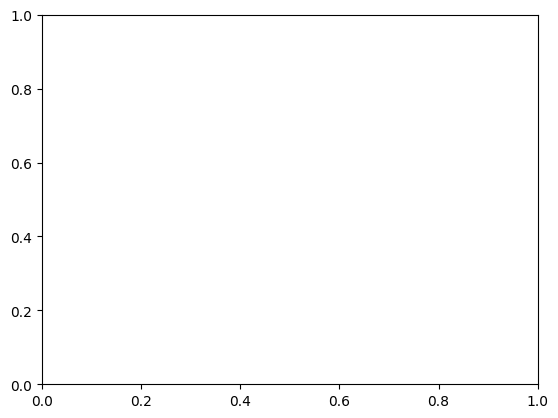

In [ ]:
fig = plt.figure()
plt.plot(range(30),train_accuracy_history,"-",linewidth=3,label="Train Error")
plt.plot(range(30),test_accuracy_history,"-",linewidth=3,label="Test Error")
plt.legend()
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
all_predicted = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        all_predicted.extend(predicted.cpu().numpy())

# Calculate accuracy using all_predicted and test_set.labels
accuracy = (np.array(all_predicted) == test_set.labels).mean()
print(f"Model Accuracy: {accuracy*100:.2f}%")

In [ ]:
torch.save(model.state_dict(),'drive/MyDrive/Colab-Data/rsp.pt')

In [ ]:
print(model(torch.tensor([0.854494893105,0.98617294483]).to(device)))